In [2]:
import json
import re
from ast import literal_eval
from datetime import datetime

import matplotlib.pyplot as plt
from pandas import DataFrame, json_normalize, read_csv, to_datetime

json_pattern = re.compile(r"\[INFO\] (.+)$")
log_pattern = re.compile(r"({.*})")


test = read_csv("../data/PAMAP2/y_train_data.csv")
x_label = [f"{num[0]}" for num in test.value_counts().index.sort_values().to_list()][1:]

In [3]:
def extract_result(file_name: str) -> DataFrame:
    records = []
    with open(f"../reports/{file_name}.log", "r") as file:
        for line in file:
            if match := log_pattern.search(line):
                raw_data = match.group(1).strip()
                data = (
                    literal_eval(raw_data)
                    if raw_data.startswith("{'")
                    or raw_data.startswith('{"')
                    and "'" in raw_data
                    else json.loads(raw_data)
                )
                # Extract datetime from JSON and normalize datetime to 'YYYY-MM-DD HH:MM:SS'
                records.append(
                    {
                        "target": data["target"],
                        "datetime": datetime.strptime(
                            data["datetime"][:19]
                            if isinstance(data["datetime"], str)
                            else data["datetime"]["datetime"],
                            "%Y-%m-%d %H:%M:%S",
                        ).strftime("%Y-%m-%d %H:%M:%S"),
                        "gamma": data["params"]["gamma"],
                        "nu": data["params"]["nu"],
                        "tol": data["params"]["tol"],
                    }
                )
    return json_normalize(records)


def normalize_result(df: DataFrame) -> DataFrame:
    return (
        df.groupby(df.index // 4)
        .agg(
            {
                "target": "mean",
                "datetime": "first",
                "gamma": "first",
                "nu": "first",
                "tol": "first",
            }
        )
        .reset_index(drop=True)
    )


def extract_datetime_part(dt_str):
    # This will capture the first 'YYYY-MM-DD HH:MM' part
    match = re.match(r"^(\d{4}-\d{2}-\d{2} \d{2}:\d{2})", dt_str)
    return match.group(1) if match else None


def split_dataframe(df, chunk_sizes):
    assert sum(chunk_sizes) <= len(df), "Chunk sizes exceed DataFrame length"

    grid_chunks = []
    start = 0
    for size in chunk_sizes:
        end = start + size
        grid_chunks.append(df.iloc[start:end].reset_index(drop=True))
        start = end

    return grid_chunks


def pick_best_target(chunks):
    best_targets = []
    labels = []

    for chunk in chunks:
        best_row = chunk.loc[chunk["target"].idxmax()]
        best_targets.append(best_row["target"])
        labels.append(
            f"γ={best_row['gamma']}\nν={best_row['nu']}\ntol={best_row['tol']}"
        )
    return best_targets, labels

In [4]:
df_grid = normalize_result(extract_result("logs_grid"))
df_grid["datetime"] = to_datetime(
    df_grid["datetime"].apply(extract_datetime_part), format="%Y-%m-%d %H:%M"
)
print(
    f"Total Time Grid Search: {df_grid['datetime'].max() - df_grid['datetime'].min()}"
)
grid_chunks = split_dataframe(df_grid, [100] + [8] * 4 + [6] * 6)

df_rand = normalize_result(extract_result("logs_rand"))
df_rand["datetime"] = to_datetime(
    df_rand["datetime"].apply(extract_datetime_part), format="%Y-%m-%d %H:%M"
)
print(
    f"Total Time Random Search: {df_rand['datetime'].max() - df_rand['datetime'].min()}"
)
rand_chunks = split_dataframe(df_rand, [100] + [5] * 10)

df_bayes = extract_result("logs_bayesian")
df_bayes["datetime"] = to_datetime(
    df_bayes["datetime"].apply(extract_datetime_part), format="%Y-%m-%d %H:%M"
)
print(
    f"Total Time Bayesian Search: {df_bayes['datetime'].max() - df_bayes['datetime'].min()}"
)
bayes_chunks = split_dataframe(df_bayes, [100] + [5] * 10)

Total Time Grid Search: 0 days 02:06:00
Total Time Random Search: 0 days 04:17:00
Total Time Bayesian Search: 0 days 02:19:00


In [6]:
def get_top_params(df):
    return (
        df.sort_values("target", ascending=False)
        .head(1)[["gamma", "nu", "tol"]]
        .to_dict("list")
    )


with open("../conf/top_results.json", "w") as f:
    json.dump(
        {
            "Grid Search": get_top_params(df_grid),
            "Random Search": get_top_params(df_rand),
            "Bayesian Opt": get_top_params(df_bayes),
        },
        f,
        indent=4,
    )


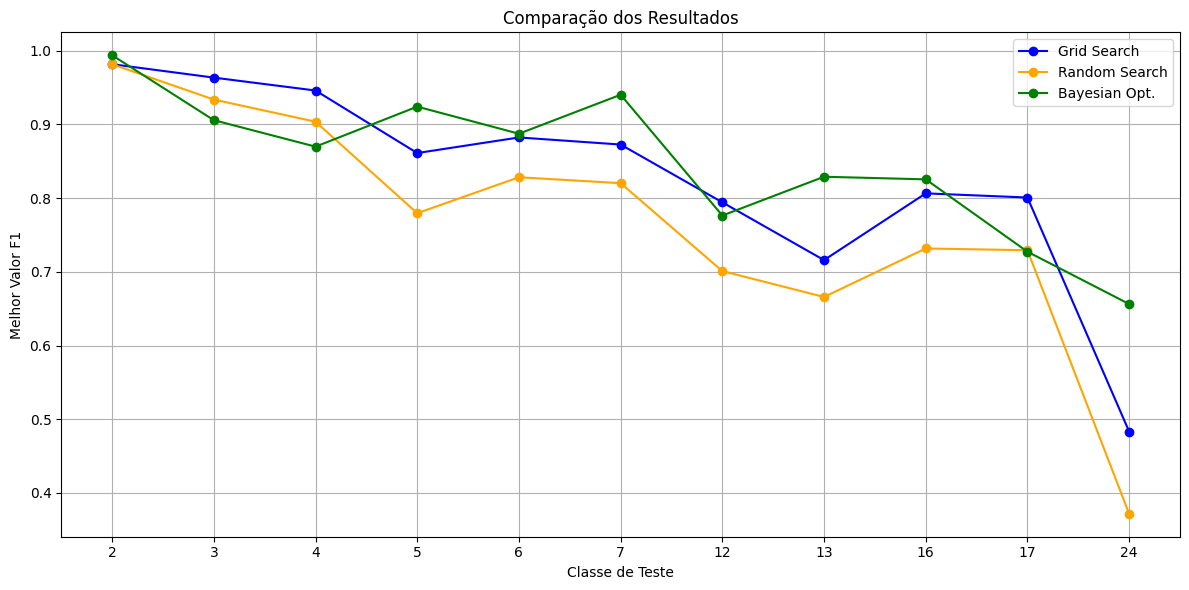

In [7]:
best_targets_grid, labels = pick_best_target(grid_chunks)
best_targets_rand, _ = pick_best_target(rand_chunks)
best_targets_bayes, _ = pick_best_target(bayes_chunks)

methods = [
    ("Grid Search", best_targets_grid, "b", labels, (0, 10), "black"),
    ("Random Search", best_targets_rand, "orange", labels, (0, -15), "orange"),
    ("Bayesian Opt.", best_targets_bayes, "green", labels, (0, -15), "green"),
]
plt.figure(figsize=(12, 6))

for name, targets, color, lbls, offset, ann_color in methods:
    plt.plot(x_label, targets, marker="o", linestyle="-", color=color, label=name)
    # for xi, yi, lbl in zip(x_label, targets, lbls):
    #     plt.annotate(
    #         lbl,
    #         (xi, yi),
    #         textcoords="offset points",
    #         xytext=offset,
    #         ha="center",
    #         fontsize=9,
    #         color=ann_color,
    #     )

plt.title("Comparação dos Resultados")
plt.xlabel("Classe de Teste")
plt.ylabel("Melhor Valor F1")
plt.xticks(x_label)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data = {
    "Pesquisa em Grade & Aleatoria": {
        "0.2": {
            "f1": 0.9591558883594282,
            "mcc": 0.692234795735105,
            "acc": 0.9276672694394213,
            "pr_auc": 0.960758665794637,
            "roc_auc": 0.76,
        },
        "0.4": {
            "f1": 0.921289095394248,
            "mcc": 0.6654563544100663,
            "acc": 0.8738838842811223,
            "pr_auc": 0.9270324381911025,
            "roc_auc": 0.7592497197054635,
        },
        "0.75": {
            "f1": 0.8612190276858107,
            "mcc": 0.6244699712132372,
            "acc": 0.8064788987034455,
            "pr_auc": 0.8781319887772944,
            "roc_auc": 0.7578218429813504,
        },
        "0.9": {
            "f1": 0.8377045414622941,
            "mcc": 0.6090816329702567,
            "acc": 0.7845521892769377,
            "pr_auc": 0.8603664349322235,
            "roc_auc": 0.7573633388549957,
        },
    },
    "Optimização Bayesiana": {
        "0.2": {
            "f1": 0.9359467135052523,
            "mcc": 0.7161845231110786,
            "acc": 0.897419036659543,
            "pr_auc": 0.9893265461300753,
            "roc_auc": 0.9321560315719294,
        },
        "0.4": {
            "f1": 0.9344546044615507,
            "mcc": 0.800453878476828,
            "acc": 0.9086312948926545,
            "pr_auc": 0.981100133783426,
            "roc_auc": 0.9324441761919731,
        },
        "0.75": {
            "f1": 0.9318389571161718,
            "mcc": 0.8497711328403695,
            "acc": 0.9224843741928819,
            "pr_auc": 0.9700660281782861,
            "roc_auc": 0.9325544313556681,
        },
        "0.9": {
            "f1": 0.9307186725568366,
            "mcc": 0.8596970792064911,
            "acc": 0.9269523519106472,
            "pr_auc": 0.9661989062093939,
            "roc_auc": 0.9325705223240631,
        },
    },
}

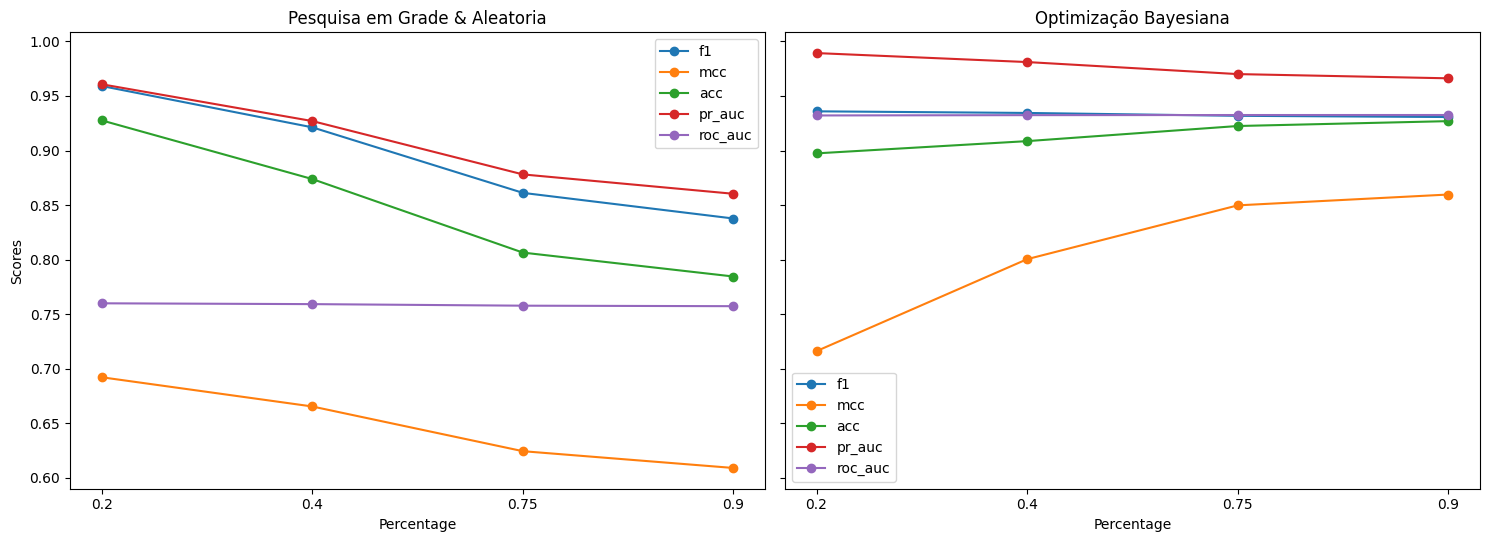

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, technique in enumerate(list(data.keys())):
    for metric in list(data["Pesquisa em Grade & Aleatoria"]["0.2"].keys()):
        axes[i].plot(
            percentages := list(data["Pesquisa em Grade & Aleatoria"].keys()),
            [data[technique][p][metric] for p in percentages],
            marker="o",
            label=metric,
        )
    axes[i].set_ylabel("Scores" if i == 0 else "")
    axes[i].set_xlabel("Percentage")  # Label x-axis as Percentage
    axes[i].set_title(technique)
    axes[i].tick_params(axis="x", rotation=0)
    axes[i].legend()  # loc="upper right")

# fig.suptitle("Performance Metrics by Percentage and Optimization Method", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()